#  VRP Miller-Tucker-Zemlin (MTZ) formulation

#### Keywords: VRP, MTZ, Miller-Tucker-Zemlin formulation, IP, Gurobi, Python, Networkx

$ \text{Variables} $

$x_{ij} = \begin{cases}
1 & \text{if the vehicle travels from node } i \text{ to node } j \\
0 & \text{otherwise}
\end{cases} \quad \forall i,j \in \{0,1,\ldots,n\},\ i \ne j$

$u_i \in \mathbb{R} \quad \forall i \in \{1, \ldots, n\}$

\begin{equation*}
\begin{aligned}
& \underset{}{\text{Minimize}} 
& & \sum_{i=0}^{n} \sum_{\substack{j=0 \\ j \ne i}}^{n} c_{ij} \, x_{ij} \\
& \text{Subject to}
& & \sum_{\substack{j=0 \\ j \ne i}}^{n} x_{ij} = 1, \quad i = 1,\ldots,n, \\
&
& & \sum_{\substack{i=0 \\ i \ne j}}^{n} x_{ij} = 1, \quad j = 1,\ldots,n, \\
&
& & \sum_{j=1}^{n} x_{0j} = K, \quad \sum_{i=1}^{n} x_{i0} = K, \\
&
& & u_i - u_j + n \cdot x_{ij} \le n - 1, \quad \forall i \ne j,\ i,j = 1,\ldots,n, \\
&
& & 1 \le u_i \le n - 1, \quad i = 1,\ldots,n, \\
&
& & x_{ij} \in \{0,1\}, \quad \forall i \ne j,\ i,j = 0,\ldots,n, \\
&
& & u_i \in \mathbb{R}, \quad i = 1,\ldots,n. \\
\end{aligned}
\end{equation*}


##  Import Library and Model Enviroment

In [1]:
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
m = gp.Model("VRP_MTZ")

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-13


### Create Data and Matrix of Distances

In [18]:
n = 24                # number of customers
K = 4                # number of vehicles
#Create a Random Matrix
c = np.random.randint(1, 100, size=(n+1, n+1))
# A_i,i = 0
np.fill_diagonal(c, 0)

### Variables

In [19]:
x = m.addVars(n+1, n+1, vtype=GRB.BINARY, name="x")
u = m.addVars(n+1, vtype=GRB.CONTINUOUS, lb=0, ub=n-1, name="u")

## Mathematical Model of VRP (MTZ Formulation)

### Objective Function

In [20]:
m.setObjective(
    gp.quicksum(c[i][j] * x[i,j] for i in range(n+1) for j in range(n+1) if i != j),
    GRB.MINIMIZE
)

### Subject to:

In [21]:
# 1) Each customer i has exactly one outgoing edge
for i in range(1, n+1):
    m.addConstr(gp.quicksum(x[i,j] for j in range(n+1) if j != i) == 1)

In [22]:
# 2) Each customer i has exactly one incoming edge
for j in range(1, n+1):
    m.addConstr(gp.quicksum(x[i,j] for i in range(n+1) if i != j) == 1)


In [23]:
# 3) Exactly K vehicles leaving/entering depot
m.addConstr(gp.quicksum(x[0,j] for j in range(1, n+1)) == K)
m.addConstr(gp.quicksum(x[i,0] for i in range(1, n+1)) == K)

<gurobi.Constr *Awaiting Model Update*>

In [24]:
# 4) MTZ constraints
for i in range(1, n+1):
    for j in range(1, n+1):
        if i != j:
            m.addConstr(u[i] - u[j] + (n+1)*x[i,j] <= n - 1)

### Solve the VRP (MTZ Formulation)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 5706 rows, 5954 columns and 27756 nonzeros
Model fingerprint: 0xd0f3f93a
Variable types: 127 continuous, 5827 integer (5827 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]

MIP start from previous solve produced solution with objective 267 (0.02s)
MIP start from previous solve produced solution with objective 220 (0.04s)
Loaded MIP start from previous solve with objective 220

Presolve removed 3154 rows and 3354 columns
Presolve time: 0.08s
Presolved: 2552 rows, 2600 columns, 12450 nonzeros
Variable types: 50 continuous, 2550 integer (2550 binary)

Explored 0 nodes (0 simplex iterations) in 0.14 seconds (

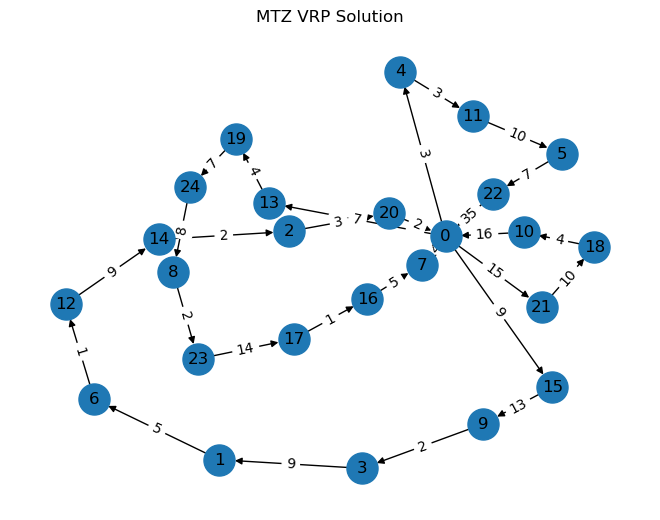

Optimal cost: 220.0
Route from 0 to 4
Route from 0 to 13
Route from 0 to 15
Route from 0 to 21
Route from 1 to 6
Route from 2 to 20
Route from 3 to 1
Route from 4 to 11
Route from 5 to 22
Route from 6 to 12
Route from 7 to 0
Route from 8 to 23
Route from 9 to 3
Route from 10 to 0
Route from 11 to 5
Route from 12 to 14
Route from 13 to 19
Route from 14 to 2
Route from 15 to 9
Route from 16 to 7
Route from 17 to 16
Route from 18 to 10
Route from 19 to 24
Route from 20 to 0
Route from 21 to 18
Route from 22 to 0
Route from 23 to 17
Route from 24 to 8


In [25]:
m.optimize()

# -------------
# NetworkX Plot
# -------------
if m.status == GRB.OPTIMAL:
    sol_x = m.getAttr('x', x)
    
    # Create directed graph
    G = nx.DiGraph()
    
    # Add nodes
    for i in range(n+1):
        G.add_node(i)
    
    # Add edges used in the solution
    for i in range(n+1):
        for j in range(n+1):
            if i != j and sol_x[i,j] > 0.5:
                G.add_edge(i, j)
    
    # Layout and draw
    pos = nx.spring_layout(G, seed=42)  # positions for all nodes
    nx.draw(G, pos, with_labels=True, node_size=500)
    edge_labels = {(i, j): c[i][j] for (i, j) in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("MTZ VRP Solution")
    plt.show()

    print("Optimal cost:", m.objVal)
    # Print route
    for i in range(n+1):
        for j in range(n+1):
            if i != j and sol_x[i,j] > 0.5:
                print(f"Route from {i} to {j}")


### Literature

Dantzig, G. and Ramser, J. (1959) The Truck Dispatching Problem. Management Science, 6, 80-91.
http://dx.doi.org/10.1287/mnsc.6.1.80